<a href="https://colab.research.google.com/github/riccardotomada/Airfoil-Analysis/blob/master/Advection%20DIffusion%20equation/ROM%20linear/POD_utilities_and_datasets_AD_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Installing FEnICS
%%capture
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin 

In [24]:
# Importing the libraries needed
from fenics import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from scipy.stats import qmc
import csv
from sklearn.decomposition import PCA

In [25]:
# FOM construction

# Generating the mesh
nx, ny = 50, 50
mesh = UnitSquareMesh(nx, ny)
dim = mesh.geometric_dimension()
print(dim)
mesh.coordinates().shape

2


(2601, 2)

In [26]:
# Setting up the measures
dx = Measure('dx', domain=mesh)

In [27]:
# Definition of finite element space
degree = 2
V = FunctionSpace(mesh, 'CG', degree)

In [28]:
# Data of the problem
bx, by = np.cos(np.pi/4.0), np.cos(np.pi/4.0)
b = Constant((bx, by))
f = Constant(0)

In [29]:
# Generating the sampling grid to retrieve the SNapshots 

x_min, x_max = 0, 1
y_min, y_max = 0, 1
grid_dim = 96

x = np.linspace(x_min, x_max, grid_dim)
y = np.linspace(y_min, y_max, grid_dim)

X = np.zeros((len(x)*len(y), 2))
xs = np.vstack((x,)*len(y)).reshape(-1)
ys = np.vstack((y,)*len(x)).T.reshape(-1)
X[:, 0] = xs
X[:, 1] = ys

In [30]:
# Definition of Dirichlet boundary conditions
gD0 = Constant(0.0)
gD1 = Constant(1.0)

In [31]:
def boundary_right(x, on_boundary):
  return on_boundary and np.isclose(x[0], 1.0)

def boundary_bottom(x, on_boundary):
  return on_boundary and np.isclose(x[1], 0.0)

def boundary_left_bottom(x, on_boundary):
  return on_boundary and np.isclose(x[0], 0.0) and (x[1] <= 0.2)

def boundary_left_top(x, on_boundary):
  return on_boundary and np.isclose(x[0], 0.0) and (x[1] >= 0.2)

def boundary_top(x, on_boundary):
  return on_boundary and np.isclose(x[1], 1.0)

bc1 = DirichletBC(V, gD0, boundary_right)
bc2 = DirichletBC(V, gD1, boundary_bottom)
bc3 = DirichletBC(V, gD1, boundary_left_bottom)
bc4 = DirichletBC(V, gD0, boundary_left_top)
bc5 = DirichletBC(V, gD0, boundary_top)

In [32]:
num_samples     = 80
truncated_modes = 15

import random
random.seed(123)

def rnd():
    exp = random.randint(-5, 1)
    significand = 0.9 * random.random() + 0.1
    return significand * 10**exp

parameters = np.array([rnd() for _ in range(num_samples)])
print(parameters.shape)

Snapshots = np.zeros((10201, parameters.shape[0]))
Snapshot_ae  = np.zeros((grid_dim**2,1))
Snapshots_ae = np.zeros((grid_dim**2, parameters.shape[0]))

for iter in range(parameters.shape[0]):
  mu  = parameters[iter]
  u = TrialFunction(V)
  v = TestFunction(V)

  a0 = (mu * dot(grad(u), grad(v))) * dx
  a1 = (dot(b, grad(u)) * v) * dx
  a  = a0 + a1
  L = f * v * dx

  # ... stabilization term
  h = CellDiameter(mesh)
  bnorm = sqrt(dot(b, b))
  Pe = bnorm*h/(2*mu)
  tau = 0.5*h/bnorm * conditional(Pe/3 > 1, 1, Pe/3)

  # ... streamline diffusion stabilization
  c = tau * dot(b, grad(u)) * dot(b, grad(v)) * dx 
  a_stab = a + c

  # 4. solving discrete problem
  u = Function(V)
  solve(a_stab == L, u, [bc1, bc2, bc3, bc4, bc5])

  Snapshot = np.array(u.vector())
  Snapshots[:, iter] = Snapshot
  for i in range(X.shape[0]):
    Snapshot_ae[i] = u(X[i][0], X[i][1])
  Snapshots_ae[:, iter] = Snapshot_ae[:,0]

(80,)


In [33]:
# Performing the Singular Value Decomposition on the Snapshots matrix
UU, SS, VV = np.linalg.svd(Snapshots, full_matrices=False)

In [34]:
# Inspecting the Singular Values
my_model = PCA(n_components = 0.999, svd_solver='full')
my_model.fit_transform(Snapshots)

n_modes = my_model.explained_variance_ratio_.cumsum().shape[0]
print("The number of modes required to capture the 99% of the variance is: " + str(n_modes))

The number of modes required to capture the 99% of the variance is: 5


(9216, 80)
(10201, 80)
(10201, 15)


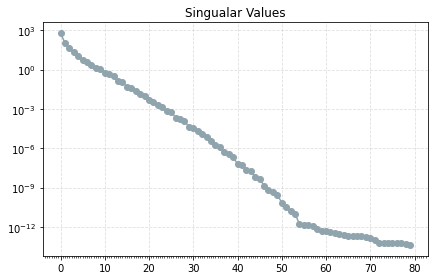

In [35]:
# Plotting the Singular Values
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(SS, marker="o", color = '#90A4AE')
plt.title("Singualar Values")
ax.xaxis.set_minor_locator(MultipleLocator(.5))
ax.yaxis.set_minor_locator(MultipleLocator(.1))
plt.grid(alpha = 0.4, linestyle='--')
fig.tight_layout()
ax.set_yscale('log')

print(Snapshots_ae.shape)
print(UU.shape)

UU = UU[:, :truncated_modes]
print(UU.shape)

In [36]:
# Retrieving the terms of the FOM for the PINN-approach
# Note: the RHS changes for each parameter
import random
random.seed(123)
num_pinn = 128

def rnd():
    exp = random.randint(-5, 1)
    significand = 0.9 * random.random() + 0.1
    return significand * 10**exp

parameters_pinn = np.array([rnd() for _ in range(num_pinn)])

L = f * v * dx
b_l = assemble(L)
bc1.apply(b_l)
bc2.apply(b_l)
bc3.apply(b_l)
bc4.apply(b_l)
bc5.apply(b_l)

b_l = np.array(b_l)

LEFT_SIDE  = np.zeros((truncated_modes, truncated_modes, num_pinn))
RIGHT_SIDE = np.matmul(np.transpose(UU), b_l) 

for iter in range(num_pinn):

  mu  = parameters_pinn[iter]
  u = TrialFunction(V)
  v = TestFunction(V)

  a0 = (mu * dot(grad(u), grad(v))) * dx
  a1 = (dot(b, grad(u)) * v) * dx
  a  = a0 + a1
  L = f * v * dx

  # ... stabilization term
  h = CellDiameter(mesh)
  bnorm = sqrt(dot(b, b))
  Pe = bnorm*h/(2*mu)
  tau = 0.5*h/bnorm * conditional(Pe/3 > 1, 1, Pe/3)

  # ... streamline diffusion stabilization
  c = tau * dot(b, grad(u)) * dot(b, grad(v)) * dx 
  a_stab = a + c
  a_stab = assemble(a_stab)
  bc1.apply(a_stab)
  bc2.apply(a_stab)
  bc3.apply(a_stab)
  bc4.apply(a_stab)
  bc5.apply(a_stab)

  a_stab = a_stab.array()
  print(a_stab.shape)
  left_side = np.matmul(np.transpose(UU), a_stab)
  left_side = np.matmul(left_side, UU)
  LEFT_SIDE[:, :, iter] = left_side

(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10201)
(10201, 10

In [37]:
# Solving the ROM at each parameter instance
solutions_y = np.zeros((truncated_modes, num_pinn))
for i in range(solutions_y.shape[1]):
  y = np.linalg.solve(LEFT_SIDE[:,:,i], RIGHT_SIDE)
  solutions_y[:, i] = y

print(solutions_y.T.shape)

(128, 15)


In [38]:
# Preparing the PINN dataset
print(parameters_pinn.shape)
data_PINN = np.append(np.expand_dims(parameters_pinn, axis = 1), solutions_y.T, axis = 1)
print(data_PINN.shape)

(128,)
(128, 16)


In [39]:
# Retrieving the Projection Coefficients for the PDNN
pro_coeff = np.matmul(np.transpose(UU), Snapshots)
pro_coeff.shape

(15, 80)

In [40]:
# Preparing the PDNN dataset

pdnn_dataset = np.zeros((num_samples, truncated_modes + 1))
pdnn_dataset[:, 0] = parameters
print(pdnn_dataset.shape)
pdnn_dataset[:, 1:] = pro_coeff.T
print(pdnn_dataset[79,:])

(80, 16)
[ 2.07609606e-02 -7.12690184e+01  5.35637238e+00  7.87173392e+00
  7.83368420e-01  1.91449931e+00 -1.19297346e+00 -9.35864567e-02
 -5.79789309e-01 -3.80129374e-01 -1.24502147e-01 -5.71280405e-02
 -1.69560595e-01 -6.13351827e-03 -1.81185711e-03  3.24756787e-03]


In [41]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [43]:
# Saving on Google Drive

np.savetxt("parameter_ad_di.csv", parameters, delimiter=",")
!cp parameter_ad_di.csv "drive/My Drive/Tesi/Advection_diffusion"
np.savetxt("coefficients_ad_di.csv", pro_coeff, delimiter=",")
!cp coefficients_ad_di.csv "drive/My Drive/Tesi/Advection_diffusion"
np.savetxt("basis_ad_di.csv", UU, delimiter=",")
!cp basis_ad_di.csv "drive/My Drive/Tesi/Advection_diffusion"
np.savetxt("snapshots_ad_di.csv", Snapshots, delimiter=",")
!cp snapshots_ad_di.csv "drive/My Drive/Tesi/Advection_diffusion"
np.savetxt("snapshots_ae_ad_di.csv", Snapshots_ae, delimiter=",")
!cp snapshots_ae_ad_di.csv "drive/My Drive/Tesi/Advection_diffusion"
#np.savetxt("LHS.csv", LEFT_SIDE, delimiter=",")
#!cp LHS.csv "drive/My Drive/Advection_diffusion"
#np.savetxt("RHS.csv", RIGHT_SIDE, delimiter=",")
#!cp RHS.csv "drive/My Drive/Advection_diffusion"
np.savetxt("pinn_dataset.txt", data_PINN, delimiter=" ")
!cp pinn_dataset.txt "drive/My Drive/Tesi/Advection_diffusion"
np.savetxt("pdnn_dataset_ad_di.txt", pdnn_dataset, delimiter=" ")
!cp pdnn_dataset_ad_di.txt "drive/My Drive/Tesi/Advection_diffusion"